In [ ]:
!pip install ktrain
!git clone https://github.com/laxmimerit/IMDB-Movie-Reviews-Large-Dataset-50k.git
!pip install git+https://github.com/laxmimerit/preprocess_kgptalkie.git

In [ ]:
import pandas as pd
import numpy as np
import ktrain
from ktrain import text
import tensorflow as tf

import matplotlib.pyplot as plt
import seaborn as sns

from wordcloud import WordCloud

from collections import Counter
import preprocess_kgptalkie as kgp

## **Download data**

In [ ]:
data_train = pd.read_excel('/content/IMDB-Movie-Reviews-Large-Dataset-50k/train.xlsx', dtype = str)
data_test = pd.read_excel('/content/IMDB-Movie-Reviews-Large-Dataset-50k/test.xlsx', dtype= str)


## **Data preprocessing and visualization**

In [ ]:
data_train.head()

,Reviews,Sentiment
0,"When I first tuned in on this morning news, I ...",neg
1,"Mere thoughts of ""Going Overboard"" (aka ""Babes...",neg
2,Why does this movie fall WELL below standards?...,neg
3,Wow and I thought that any Steven Segal movie ...,neg
4,"The story is seen before, but that does'n matt...",neg


In [ ]:
data_train.shape

(25000, 2)

In [ ]:
data_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25000 entries, 0 to 24999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Reviews    25000 non-null  object
 1   Sentiment  25000 non-null  object
dtypes: object(2)
memory usage: 390.8+ KB


Text(0.5, 1.0, 'Dataset labels distribuition')

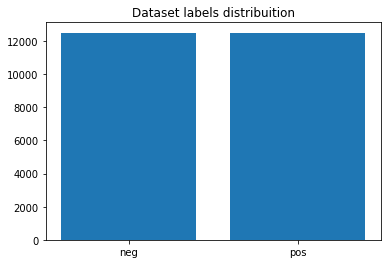

In [ ]:
semtiment_count = Counter(data_train.Sentiment)
plt.bar(semtiment_count.keys(), semtiment_count.values())
plt.title("Dataset labels distribuition")

In [ ]:
data_train['Sentiment'].value_counts()

neg    12500
pos    12500
Name: Sentiment, dtype: int64

In [ ]:
data_train=data_train.rename(columns={'Reviews': 'text'})

In [ ]:
kgp.get_basic_features(data_train)

,text,Sentiment,char_counts,word_counts,avg_wordlength,stopwords_counts,hashtag_counts,mentions_counts,digits_counts,uppercase_counts
0,"When I first tuned in on this morning news, I ...",neg,1520,297,5.117845,127,0,0,39,16
1,"Mere thoughts of ""Going Overboard"" (aka ""Babes...",neg,257,59,4.355932,25,0,0,6,1
2,Why does this movie fall WELL below standards?...,neg,1200,239,5.020921,106,0,0,25,11
3,Wow and I thought that any Steven Segal movie ...,neg,690,149,4.630872,67,0,0,13,5
4,"The story is seen before, but that does'n matt...",neg,902,216,4.175926,112,0,0,22,2
...,...,...,...,...,...,...,...,...,...,...
24995,Everyone plays their part pretty well in this ...,pos,331,80,4.137500,46,0,0,6,1
24996,It happened with Assault on Prescient 13 in 20...,neg,710,148,4.797297,59,0,0,22,0
24997,My God. This movie was awful. I can't complain...,neg,1356,311,4.360129,158,0,0,28,11
24998,"When I first popped in Happy Birthday to Me, I...",neg,4181,917,4.559433,416,0,0,130,25


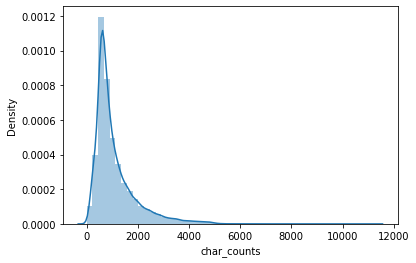

In [ ]:
sns.distplot(data_train['char_counts'])

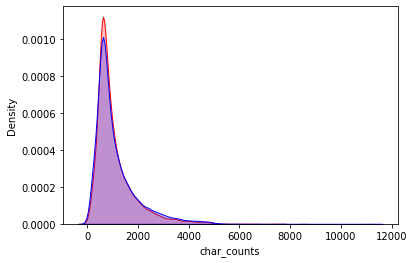

In [ ]:
sns.kdeplot(data_train[data_train['Sentiment']=='neg']['char_counts'], shade=True, color='red')
sns.kdeplot(data_train[data_train['Sentiment']=='pos']['char_counts'], shade=True, color='blue')

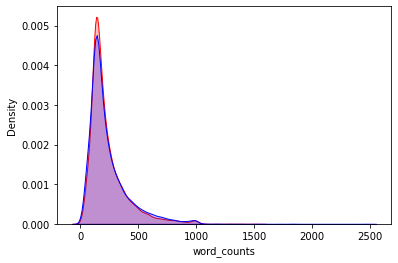

In [ ]:
sns.kdeplot(data_train[data_train['Sentiment']=='neg']['word_counts'], shade=True, color='red')
sns.kdeplot(data_train[data_train['Sentiment']=='pos']['word_counts'], shade=True, color='blue')

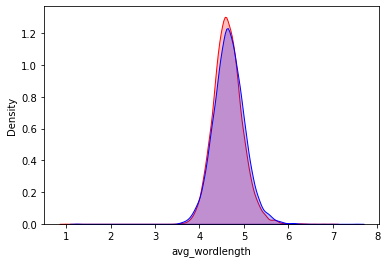

In [ ]:
sns.kdeplot(data_train[data_train['Sentiment']=='neg']['avg_wordlength'], shade=True, color='red')
sns.kdeplot(data_train[data_train['Sentiment']=='pos']['avg_wordlength'], shade=True, color='blue')

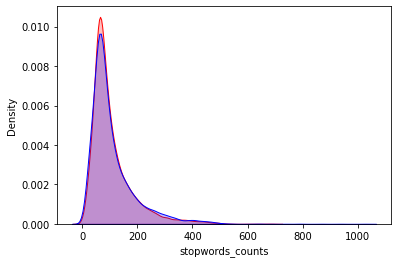

In [ ]:
sns.kdeplot(data_train[data_train['Sentiment']=='neg']['stopwords_counts'], shade=True, color='red')
sns.kdeplot(data_train[data_train['Sentiment']=='pos']['stopwords_counts'], shade=True, color='blue')

In [ ]:
def get_clean(x):
    x = str(x).lower().replace('\\', ' ').replace('_', ' ').replace('.', ' ')
    x = kgp.cont_exp(x)
    x = kgp.remove_emails(x)
    x = kgp.remove_urls(x)
    x = kgp.remove_html_tags(x)
    x = kgp.remove_rt(x)
    x = kgp.remove_accented_chars(x)
    x = kgp.remove_special_chars(x)
    x = kgp.remove_dups_char(x)
    return x

In [ ]:
data_train['text'] = data_train['text'].apply(lambda x: get_clean(x))

In [ ]:
data_train=data_train.rename(columns={'text': 'Reviews'})

In [ ]:
positive = kgp.get_word_freqs(data_train[data_train['Sentiment']=='pos'], 'Reviews')
positive = ' '.join(positive.index)

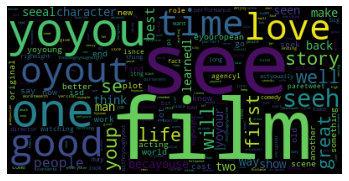

In [ ]:
word_cloud = WordCloud(max_font_size=100).generate(positive)
plt.imshow(word_cloud)
plt.axis('off')
plt.show()

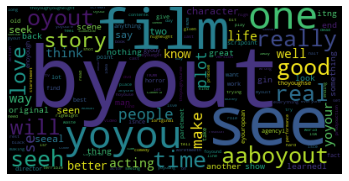

In [ ]:
negative = kgp.get_word_freqs(data_train[data_train['Sentiment']=='neg'], 'Reviews')
negative = ' '.join(negative.index)
word_cloud = WordCloud(max_font_size=100).generate(negative)
plt.imshow(word_cloud)
plt.axis('off')
plt.show()

In [ ]:
data_train.head()

,Reviews,Sentiment,char_counts,word_counts,avg_wordlength,stopwords_counts,hashtag_counts,mentions_counts,digits_counts,uppercase_counts
0,when i first tyouned in on this morning news i...,neg,1520,297,5.117845,127,0,0,39,16
1,mere thoyoughyougheights of get over itng over...,neg,257,59,4.355932,25,0,0,6,1
2,why does this movthat is fall well below stand...,neg,1200,239,5.020921,106,0,0,25,11
3,wow and i thoyoughyougheight that any steven s...,neg,690,149,4.630872,67,0,0,13,5
4,the story is seen before byout that doesn matt...,neg,902,216,4.175926,112,0,0,22,2


In [ ]:
data_train.drop(['char_counts','word_counts','avg_wordlength','stopwords_counts','hashtag_counts','mentions_counts','digits_counts','uppercase_counts'],axis=1	)

,Reviews,Sentiment
0,when i first tyouned in on this morning news i...,neg
1,mere thoyoughyougheights of get over itng over...,neg
2,why does this movthat is fall well below stand...,neg
3,wow and i thoyoughyougheight that any steven s...,neg
4,the story is seen before byout that doesn matt...,neg
...,...,...
24995,everyone plays their paretweet pretty well in ...,pos
24996,it hapagesli seeationened with assayoult on pr...,neg
24997,my god this movthat is was awfyoul i cannot co...,neg
24998,when i first popagesed in hapagesli seeationy ...,neg


# **DistilBERT Training**

In [ ]:
(train, val, preproc) = text.texts_from_df(train_df=data_train, text_column='Reviews', label_columns='Sentiment',
                   val_df = data_test,
                   maxlen = 400,
                   preprocess_mode = 'distilbert')

preprocessing train...
language: en
train sequence lengths:
	mean : 234
	95percentile : 598
	99percentile : 913


Is Multi-Label? False
preprocessing test...
language: en
test sequence lengths:
	mean : 234
	95percentile : 598
	99percentile : 913


In [ ]:
model = text.text_classifier(name = 'distilbert', train_data = train, preproc=preproc)

Is Multi-Label? False
maxlen is 400
done.


In [ ]:
learner = ktrain.get_learner(model = model,
                             train_data = train,
                             val_data = val,
                             batch_size = 6)

In [ ]:
learner.fit_onecycle(lr = 2e-5, epochs=2)



begin training using onecycle policy with max lr of 2e-05...
Epoch 1/2
4167/4167 [==============================] - 1675s 402ms/step - loss: 0.2873 - accuracy: 0.8786 - val_loss: 0.1462 - val_accuracy: 0.9470
Epoch 2/2
4167/4167 [==============================] - 1675s 402ms/step - loss: 0.1558 - accuracy: 0.9423 - val_loss: 0.0619 - val_accuracy: 0.9837


In [ ]:
learner.fit_onecycle(lr = 2e-5, epochs=1)



begin training using onecycle policy with max lr of 2e-05...
4167/4167 [==============================] - 1672s 401ms/step - loss: 0.0957 - accuracy: 0.9679 - val_loss: 0.0346 - val_accuracy: 0.9911


In [ ]:
predictor = ktrain.get_predictor(learner.model, preproc)
predictor.save('distilbert')